In [1]:
import torch as tc 
from torch import optim, nn 
from torch.utils.data import DataLoader, TensorDataset, random_split 

import torchvision.transforms.functional as fn
from torchvision import datasets
from torchvision import transforms as T

from torchmetrics import Accuracy

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split 

import cv2
from PIL import Image

from tqdm import tqdm 

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transforms_train = T.Compose([T.ToTensor(), T.Resize(size = (128, 128)), T.Normalize(mean = [0.7437, 0.5865, 0.5869], std = [0.0816, 0.1087, 0.1215])])
transforms_valid = T.Compose([T.ToTensor(), T.Resize(size = (128, 128)), T.Normalize(mean = [0.7437, 0.5865, 0.5869], std = [0.0816, 0.1087, 0.1215])])

In [3]:
#train_dataset = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/datasets/skin cancer detection using cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train', transform = transforms_train)
data = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/datasets/skin cancer detection using cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train', 
                            transform = T.Compose([T.ToTensor(),
                                                   T.Resize(size = (64, 64))]))

In [4]:
t, _ = random_split(data, (300, len(data)-300), generator = tc.Generator().manual_seed(42))

In [5]:
#valid_dataset = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/datasets/skin cancer detection using cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Test', transform = transforms_valid)
train_dataset, valid_dataset = random_split(t, (250, len(t)-250), generator = tc.Generator().manual_seed(42))

In [6]:
len(train_dataset), len(valid_dataset)

(250, 50)

In [7]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 50, shuffle = False)

In [8]:
model = nn.Sequential(nn.LazyConv2d(16, 3, 1, 1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2, 2), 
                      nn.LazyConv2d(32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
                      nn.LazyConv2d(64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
                      nn.LazyConv2d(128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.AdaptiveAvgPool2d(output_size=(1, 1)),
                      
                      nn.Flatten(),
                      nn.LazyLinear(9))

/home/ahmadrezabaqerzadeh/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
device = 'cuda' if tc.cuda.is_available() else 'cpu' 

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
def train_one_epoch(model, train_loader, loss_func, optimizer, epoch):
    model.train()

    train_loss=AverageMeter()
    train_acc=Accuracy(task='multiclass', num_classes=9).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for x, y in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            x=x.to(device)
            y=y.to(device)

            yp=model(x)
            loss=loss_func(yp.squeeze(),  y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss.item())
            train_acc(yp.squeeze(), y)

            tepoch.set_postfix(loss=train_loss.avg, Accuracy=train_acc.compute().item() * 100)

    return model, train_loss.avg, train_acc.compute().item()

In [12]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task='multiclass', num_classes=9).to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp.squeeze(), y)

        valid_loss.update(loss.item())
        valid_acc(yp.squeeze(), y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute().item() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item()

In [13]:
mini_batch, _ = random_split(train_dataset, (10, len(train_dataset)-10))
mini_loader = DataLoader(mini_batch, batch_size=10, shuffle=True)

In [14]:
model = model.to(device)

In [15]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_func = nn.CrossEntropyLoss()

In [16]:
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []

best_loss = tc.inf 
best_model = [0]

In [17]:
N = 35
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 4/4 [00:04<00:00,  1.12s/batch, Accuracy=18.8, loss=2.07]


valid loss=2.209, accuracy=20.0

model saved!


Epoch=1: 100%|██████████| 4/4 [00:03<00:00,  1.20batch/s, Accuracy=39.6, loss=1.77]


valid loss=2.215, accuracy=20.0



Epoch=2: 100%|██████████| 4/4 [00:03<00:00,  1.23batch/s, Accuracy=44.4, loss=1.65]


valid loss=2.253, accuracy=20.0



Epoch=3: 100%|██████████| 4/4 [00:03<00:00,  1.25batch/s, Accuracy=42.8, loss=1.57]


valid loss=2.283, accuracy=20.0



Epoch=4: 100%|██████████| 4/4 [00:03<00:00,  1.22batch/s, Accuracy=44, loss=1.51]  


valid loss=2.273, accuracy=20.0



Epoch=5: 100%|██████████| 4/4 [00:03<00:00,  1.22batch/s, Accuracy=48.4, loss=1.46]


valid loss=2.245, accuracy=22.0



Epoch=6: 100%|██████████| 4/4 [00:03<00:00,  1.21batch/s, Accuracy=48.8, loss=1.42]


valid loss=2.214, accuracy=24.0



Epoch=7: 100%|██████████| 4/4 [00:03<00:00,  1.23batch/s, Accuracy=50.4, loss=1.4] 


valid loss=2.192, accuracy=26.0

model saved!


Epoch=8: 100%|██████████| 4/4 [00:03<00:00,  1.19batch/s, Accuracy=51.6, loss=1.36]


valid loss=2.086, accuracy=26.0

model saved!


Epoch=9: 100%|██████████| 4/4 [00:03<00:00,  1.17batch/s, Accuracy=54, loss=1.32]  


valid loss=1.961, accuracy=30.0

model saved!


Epoch=10: 100%|██████████| 4/4 [00:03<00:00,  1.20batch/s, Accuracy=56.4, loss=1.29]


valid loss=1.841, accuracy=30.0

model saved!


Epoch=11: 100%|██████████| 4/4 [00:03<00:00,  1.22batch/s, Accuracy=56.4, loss=1.27]


valid loss=1.784, accuracy=34.0

model saved!


Epoch=12: 100%|██████████| 4/4 [00:03<00:00,  1.18batch/s, Accuracy=59.2, loss=1.21]


valid loss=1.687, accuracy=38.0

model saved!


Epoch=13: 100%|██████████| 4/4 [00:03<00:00,  1.23batch/s, Accuracy=57.2, loss=1.21]


valid loss=1.654, accuracy=38.0

model saved!


Epoch=14: 100%|██████████| 4/4 [00:03<00:00,  1.22batch/s, Accuracy=62.4, loss=1.18]


valid loss=1.655, accuracy=36.0



Epoch=15: 100%|██████████| 4/4 [00:03<00:00,  1.31batch/s, Accuracy=60.8, loss=1.13]


valid loss=1.624, accuracy=38.0

model saved!


Epoch=16: 100%|██████████| 4/4 [00:03<00:00,  1.29batch/s, Accuracy=62, loss=1.12]  


valid loss=1.65, accuracy=34.0



Epoch=17: 100%|██████████| 4/4 [00:03<00:00,  1.29batch/s, Accuracy=60.8, loss=1.12] 


valid loss=1.654, accuracy=40.0



Epoch=18: 100%|██████████| 4/4 [00:03<00:00,  1.30batch/s, Accuracy=62.8, loss=1.06]


valid loss=1.591, accuracy=46.0

model saved!


Epoch=19: 100%|██████████| 4/4 [00:03<00:00,  1.27batch/s, Accuracy=65.6, loss=1.06]


valid loss=1.708, accuracy=36.0



Epoch=20: 100%|██████████| 4/4 [00:03<00:00,  1.31batch/s, Accuracy=63.6, loss=0.992]


valid loss=1.65, accuracy=40.0



Epoch=21: 100%|██████████| 4/4 [00:02<00:00,  1.34batch/s, Accuracy=64.4, loss=0.982]


valid loss=1.575, accuracy=48.0

model saved!


Epoch=22: 100%|██████████| 4/4 [00:03<00:00,  1.28batch/s, Accuracy=64.4, loss=0.985]


valid loss=1.858, accuracy=40.0



Epoch=23: 100%|██████████| 4/4 [00:03<00:00,  1.31batch/s, Accuracy=70.4, loss=0.92] 


valid loss=1.632, accuracy=40.0



Epoch=24: 100%|██████████| 4/4 [00:03<00:00,  1.28batch/s, Accuracy=71.2, loss=0.92] 


valid loss=1.65, accuracy=48.0



Epoch=25: 100%|██████████| 4/4 [00:03<00:00,  1.32batch/s, Accuracy=70.4, loss=0.89] 


valid loss=1.714, accuracy=36.0



Epoch=26: 100%|██████████| 4/4 [00:03<00:00,  1.31batch/s, Accuracy=68.8, loss=0.871]


valid loss=2.206, accuracy=42.0



Epoch=27: 100%|██████████| 4/4 [00:03<00:00,  1.29batch/s, Accuracy=74, loss=0.817]  


valid loss=1.659, accuracy=50.0



Epoch=28: 100%|██████████| 4/4 [00:03<00:00,  1.32batch/s, Accuracy=74.8, loss=0.811]


valid loss=1.599, accuracy=48.0



Epoch=29: 100%|██████████| 4/4 [00:03<00:00,  1.33batch/s, Accuracy=75.2, loss=0.78] 


valid loss=2.072, accuracy=38.0



Epoch=30: 100%|██████████| 4/4 [00:03<00:00,  1.32batch/s, Accuracy=73.6, loss=0.783]


valid loss=1.686, accuracy=36.0



Epoch=31: 100%|██████████| 4/4 [00:03<00:00,  1.30batch/s, Accuracy=76, loss=0.743]  


valid loss=1.887, accuracy=38.0



Epoch=32: 100%|██████████| 4/4 [00:03<00:00,  1.32batch/s, Accuracy=77.6, loss=0.71] 


valid loss=1.759, accuracy=38.0



Epoch=33: 100%|██████████| 4/4 [00:03<00:00,  1.31batch/s, Accuracy=77.2, loss=0.751]


valid loss=1.62, accuracy=46.0



Epoch=34: 100%|██████████| 4/4 [00:03<00:00,  1.32batch/s, Accuracy=82.8, loss=0.643]


valid loss=1.886, accuracy=40.0



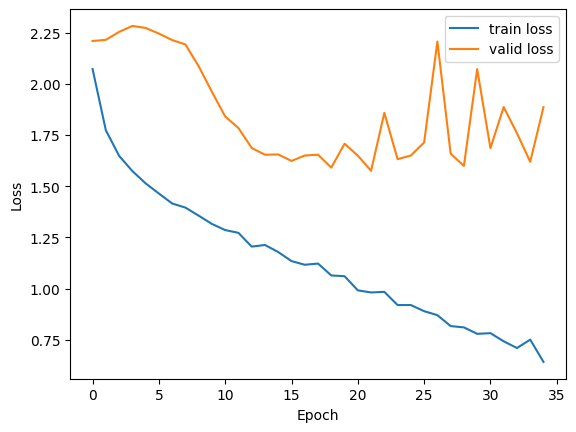

In [18]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

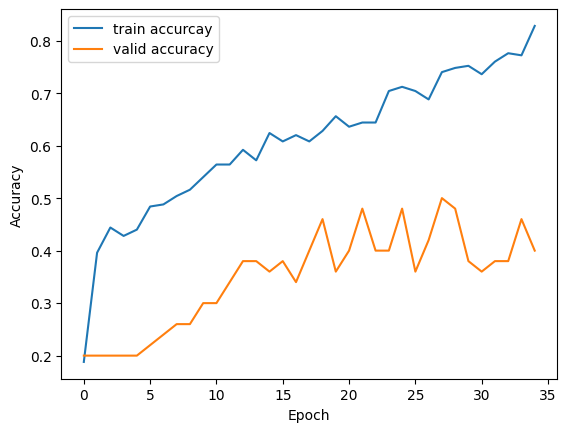

In [19]:
plt.plot(range(N), acc_train_hist, label = 'train accurcay')
plt.plot(range(N), acc_valid_hist, label = 'valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
transforms_train = T.Compose([T.ToTensor(),
                              T.Resize(size = (64, 64)),
                             T.RandomGrayscale(0.5)])

In [21]:
data = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/datasets/skin cancer detection using cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train', 
                            transform = transforms_train)

In [22]:
t, _ = random_split(data, (200, len(data)-200), generator = tc.Generator().manual_seed(42))

In [23]:
train_dataset, valid_dataset = random_split(t, (150, len(t)-150), generator = tc.Generator().manual_seed(42))

In [24]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 50, shuffle = False)

In [25]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_func = nn.CrossEntropyLoss()

In [26]:
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []

In [27]:
N = 25
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 3/3 [00:01<00:00,  1.60batch/s, Accuracy=39.3, loss=1.97]


valid loss=2.487, accuracy=46.0



Epoch=1: 100%|██████████| 3/3 [00:01<00:00,  1.56batch/s, Accuracy=42.7, loss=1.55]


valid loss=1.937, accuracy=44.0



Epoch=2: 100%|██████████| 3/3 [00:02<00:00,  1.46batch/s, Accuracy=49.3, loss=1.61]


valid loss=1.731, accuracy=50.0



Epoch=3: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s, Accuracy=40.7, loss=1.84]


valid loss=1.471, accuracy=54.0

model saved!


Epoch=4: 100%|██████████| 3/3 [00:01<00:00,  1.55batch/s, Accuracy=40.7, loss=1.92]


valid loss=1.811, accuracy=48.0



Epoch=5: 100%|██████████| 3/3 [00:01<00:00,  1.57batch/s, Accuracy=41.3, loss=1.73]


valid loss=1.839, accuracy=48.0



Epoch=6: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s, Accuracy=44, loss=1.75]  


valid loss=1.907, accuracy=46.0



Epoch=7: 100%|██████████| 3/3 [00:01<00:00,  1.54batch/s, Accuracy=42.7, loss=1.87]


valid loss=1.597, accuracy=46.0



Epoch=8: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=34.7, loss=1.85]


valid loss=1.649, accuracy=38.0



Epoch=9: 100%|██████████| 3/3 [00:01<00:00,  1.63batch/s, Accuracy=41.3, loss=1.8] 


valid loss=1.716, accuracy=46.0



Epoch=10: 100%|██████████| 3/3 [00:01<00:00,  1.55batch/s, Accuracy=44, loss=1.93]  


valid loss=1.561, accuracy=44.0



Epoch=11: 100%|██████████| 3/3 [00:01<00:00,  1.65batch/s, Accuracy=42.7, loss=1.67]


valid loss=1.626, accuracy=44.0



Epoch=12: 100%|██████████| 3/3 [00:01<00:00,  1.55batch/s, Accuracy=41.3, loss=1.63]


valid loss=1.794, accuracy=46.0



Epoch=13: 100%|██████████| 3/3 [00:01<00:00,  1.53batch/s, Accuracy=50, loss=1.61]  


valid loss=1.842, accuracy=40.0



Epoch=14: 100%|██████████| 3/3 [00:01<00:00,  1.55batch/s, Accuracy=38.7, loss=1.85]


valid loss=1.787, accuracy=50.0



Epoch=15: 100%|██████████| 3/3 [00:01<00:00,  1.57batch/s, Accuracy=44, loss=1.69]  


valid loss=1.824, accuracy=46.0



Epoch=16: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s, Accuracy=43.3, loss=1.8] 


valid loss=2.057, accuracy=40.0



Epoch=17: 100%|██████████| 3/3 [00:02<00:00,  1.47batch/s, Accuracy=46, loss=1.69]  


valid loss=2.1, accuracy=40.0



Epoch=18: 100%|██████████| 3/3 [00:02<00:00,  1.48batch/s, Accuracy=48, loss=1.68]  


valid loss=1.919, accuracy=48.0



Epoch=19: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=43.3, loss=1.7] 


valid loss=1.927, accuracy=48.0



Epoch=20: 100%|██████████| 3/3 [00:01<00:00,  1.56batch/s, Accuracy=41.3, loss=1.66]


valid loss=1.876, accuracy=40.0



Epoch=21: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s, Accuracy=41.3, loss=2.07]


valid loss=1.837, accuracy=44.0



Epoch=22: 100%|██████████| 3/3 [00:01<00:00,  1.53batch/s, Accuracy=46.7, loss=1.73]


valid loss=1.59, accuracy=46.0



Epoch=23: 100%|██████████| 3/3 [00:01<00:00,  1.56batch/s, Accuracy=38, loss=1.98]  


valid loss=1.72, accuracy=46.0



Epoch=24: 100%|██████████| 3/3 [00:01<00:00,  1.54batch/s, Accuracy=42, loss=1.72]  


valid loss=1.819, accuracy=40.0



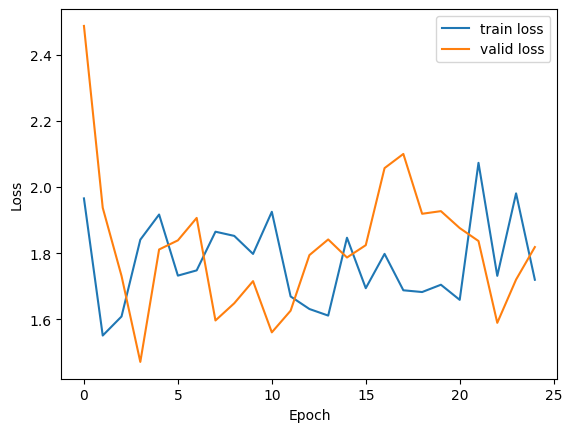

In [28]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [187]:
model = nn.Sequential(nn.LazyConv2d(16, 3, 1, 1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2, 2), 
                      nn.LazyConv2d(32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2), 
                      nn.LazyConv2d(64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2), 
                      nn.LazyConv2d(64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
                      nn.LazyConv2d(128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.AdaptiveAvgPool2d(output_size=(1, 1)),
                      
                      nn.Flatten(),
                      nn.LazyLinear(9))

In [188]:
model = model.to(device)

In [189]:
transforms_train = T.Compose([T.ToTensor(),
                              T.Resize(size = (64, 64))])

In [190]:
t, _ = random_split(data, (200, len(data)-200), generator = tc.Generator().manual_seed(42))

In [191]:
train_dataset, valid_dataset = random_split(t, (150, len(t)-150), generator = tc.Generator().manual_seed(42))

In [192]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 50, shuffle = False)

In [193]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
loss_func = nn.CrossEntropyLoss()

In [194]:
loss_train_hist, loss_valid_hist = [], []
acc_train_hist, acc_valid_hist = [], []

In [195]:
best_loss = tc.inf 
best_model = [0]

In [196]:
N = 50
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s, Accuracy=18, loss=2.19]  


valid loss=2.2, accuracy=4.0

model saved!


Epoch=1: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s, Accuracy=18.7, loss=2.1] 


valid loss=2.207, accuracy=16.0



Epoch=2: 100%|██████████| 3/3 [00:01<00:00,  1.58batch/s, Accuracy=22, loss=2.01]  


valid loss=2.221, accuracy=16.0



Epoch=3: 100%|██████████| 3/3 [00:01<00:00,  1.54batch/s, Accuracy=29.3, loss=1.93]


valid loss=2.243, accuracy=16.0



Epoch=4: 100%|██████████| 3/3 [00:01<00:00,  1.88batch/s, Accuracy=33.3, loss=1.88]


valid loss=2.273, accuracy=16.0



Epoch=5: 100%|██████████| 3/3 [00:01<00:00,  1.73batch/s, Accuracy=36, loss=1.82]  


valid loss=2.305, accuracy=16.0



Epoch=6: 100%|██████████| 3/3 [00:01<00:00,  1.54batch/s, Accuracy=38, loss=1.81]  


valid loss=2.339, accuracy=16.0



Epoch=7: 100%|██████████| 3/3 [00:01<00:00,  1.58batch/s, Accuracy=41.3, loss=1.78]


valid loss=2.371, accuracy=16.0



Epoch=8: 100%|██████████| 3/3 [00:01<00:00,  1.53batch/s, Accuracy=42, loss=1.74]  


valid loss=2.396, accuracy=16.0



Epoch=9: 100%|██████████| 3/3 [00:02<00:00,  1.50batch/s, Accuracy=43.3, loss=1.76]


valid loss=2.413, accuracy=16.0



Epoch=10: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s, Accuracy=44, loss=1.68]  


valid loss=2.415, accuracy=16.0



Epoch=11: 100%|██████████| 3/3 [00:02<00:00,  1.47batch/s, Accuracy=46, loss=1.66]  


valid loss=2.404, accuracy=16.0



Epoch=12: 100%|██████████| 3/3 [00:01<00:00,  1.54batch/s, Accuracy=46, loss=1.63]  


valid loss=2.372, accuracy=16.0



Epoch=13: 100%|██████████| 3/3 [00:01<00:00,  1.53batch/s, Accuracy=46, loss=1.59]  


valid loss=2.332, accuracy=14.0



Epoch=14: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s, Accuracy=52, loss=1.55]


valid loss=2.277, accuracy=14.0



Epoch=15: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=52, loss=1.53]  


valid loss=2.219, accuracy=14.0



Epoch=16: 100%|██████████| 3/3 [00:02<00:00,  1.47batch/s, Accuracy=54, loss=1.55]  


valid loss=2.163, accuracy=16.0

model saved!


Epoch=17: 100%|██████████| 3/3 [00:02<00:00,  1.48batch/s, Accuracy=54.7, loss=1.51]


valid loss=2.101, accuracy=20.0

model saved!


Epoch=18: 100%|██████████| 3/3 [00:02<00:00,  1.50batch/s, Accuracy=56, loss=1.48]  


valid loss=2.046, accuracy=26.0

model saved!


Epoch=19: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s, Accuracy=54, loss=1.54]  


valid loss=2.003, accuracy=28.0

model saved!


Epoch=20: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=55.3, loss=1.47]


valid loss=1.983, accuracy=28.0

model saved!


Epoch=21: 100%|██████████| 3/3 [00:02<00:00,  1.46batch/s, Accuracy=56.7, loss=1.47]


valid loss=1.957, accuracy=30.0

model saved!


Epoch=22: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=56.7, loss=1.46]


valid loss=1.923, accuracy=30.0

model saved!


Epoch=23: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=59.3, loss=1.45]


valid loss=1.905, accuracy=32.0

model saved!


Epoch=24: 100%|██████████| 3/3 [00:02<00:00,  1.46batch/s, Accuracy=59.3, loss=1.35]


valid loss=1.892, accuracy=34.0

model saved!


Epoch=25: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=61.3, loss=1.36]


valid loss=1.883, accuracy=36.0

model saved!


Epoch=26: 100%|██████████| 3/3 [00:02<00:00,  1.47batch/s, Accuracy=58.7, loss=1.33]


valid loss=1.878, accuracy=40.0

model saved!


Epoch=27: 100%|██████████| 3/3 [00:02<00:00,  1.46batch/s, Accuracy=60.7, loss=1.35]


valid loss=1.863, accuracy=42.0

model saved!


Epoch=28: 100%|██████████| 3/3 [00:01<00:00,  1.50batch/s, Accuracy=62, loss=1.28]  


valid loss=1.85, accuracy=40.0

model saved!


Epoch=29: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=62.7, loss=1.31]


valid loss=1.837, accuracy=40.0

model saved!


Epoch=30: 100%|██████████| 3/3 [00:02<00:00,  1.48batch/s, Accuracy=62.7, loss=1.27]


valid loss=1.833, accuracy=38.0

model saved!


Epoch=31: 100%|██████████| 3/3 [00:02<00:00,  1.44batch/s, Accuracy=63.3, loss=1.23]


valid loss=1.837, accuracy=36.0



Epoch=32: 100%|██████████| 3/3 [00:02<00:00,  1.46batch/s, Accuracy=62.7, loss=1.25]


valid loss=1.85, accuracy=36.0



Epoch=33: 100%|██████████| 3/3 [00:02<00:00,  1.41batch/s, Accuracy=62.7, loss=1.18]


valid loss=1.852, accuracy=38.0



Epoch=34: 100%|██████████| 3/3 [00:02<00:00,  1.44batch/s, Accuracy=62.7, loss=1.27]


valid loss=1.848, accuracy=40.0



Epoch=35: 100%|██████████| 3/3 [00:02<00:00,  1.40batch/s, Accuracy=61.3, loss=1.23]


valid loss=1.85, accuracy=40.0



Epoch=36: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=68, loss=1.18]  


valid loss=1.838, accuracy=42.0



Epoch=37: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=66.7, loss=1.21]


valid loss=1.831, accuracy=40.0

model saved!


Epoch=38: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=68, loss=1.21]  


valid loss=1.824, accuracy=38.0

model saved!


Epoch=39: 100%|██████████| 3/3 [00:02<00:00,  1.46batch/s, Accuracy=68, loss=1.19]  


valid loss=1.826, accuracy=38.0



Epoch=40: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=65.3, loss=1.11]


valid loss=1.811, accuracy=36.0

model saved!


Epoch=41: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=69.3, loss=1.11]


valid loss=1.804, accuracy=36.0

model saved!


Epoch=42: 100%|██████████| 3/3 [00:02<00:00,  1.44batch/s, Accuracy=75.3, loss=1.14]


valid loss=1.798, accuracy=38.0

model saved!


Epoch=43: 100%|██████████| 3/3 [00:02<00:00,  1.44batch/s, Accuracy=71.3, loss=1.05]


valid loss=1.8, accuracy=40.0



Epoch=44: 100%|██████████| 3/3 [00:02<00:00,  1.44batch/s, Accuracy=72, loss=1.1]   


valid loss=1.796, accuracy=42.0

model saved!


Epoch=45: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=76, loss=1.03]  


valid loss=1.789, accuracy=40.0

model saved!


Epoch=46: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=74, loss=1.02]  


valid loss=1.797, accuracy=40.0



Epoch=47: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=75.3, loss=1.04] 


valid loss=1.799, accuracy=40.0



Epoch=48: 100%|██████████| 3/3 [00:01<00:00,  1.50batch/s, Accuracy=72.7, loss=1.03] 


valid loss=1.798, accuracy=42.0



Epoch=49: 100%|██████████| 3/3 [00:02<00:00,  1.46batch/s, Accuracy=80, loss=0.984]  


valid loss=1.789, accuracy=42.0



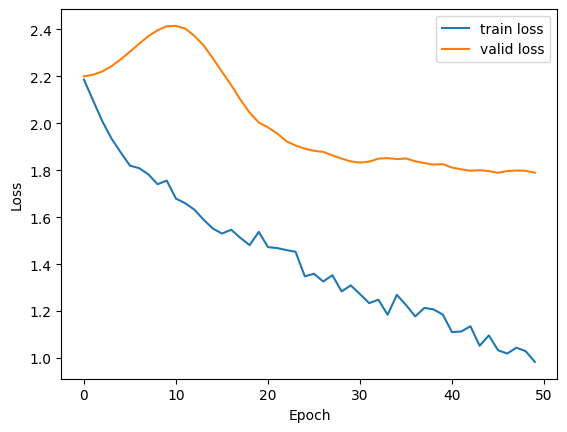

In [197]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [198]:
loss_train_hist, loss_valid_hist = [], []
acc_train_hist, acc_valid_hist = [], []

In [199]:
N = 50
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 3/3 [00:01<00:00,  1.59batch/s, Accuracy=78.7, loss=1.06] 


valid loss=1.789, accuracy=44.0

model saved!


Epoch=1: 100%|██████████| 3/3 [00:01<00:00,  1.53batch/s, Accuracy=78, loss=0.979]  


valid loss=1.798, accuracy=42.0



Epoch=2: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=81.3, loss=0.927]


valid loss=1.778, accuracy=44.0

model saved!


Epoch=3: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s, Accuracy=84.7, loss=0.894]


valid loss=1.761, accuracy=42.0

model saved!


Epoch=4: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=84, loss=0.909]  


valid loss=1.769, accuracy=42.0



Epoch=5: 100%|██████████| 3/3 [00:02<00:00,  1.39batch/s, Accuracy=84.7, loss=0.901]


valid loss=1.775, accuracy=40.0



Epoch=6: 100%|██████████| 3/3 [00:02<00:00,  1.46batch/s, Accuracy=81.3, loss=0.925]


valid loss=1.765, accuracy=38.0



Epoch=7: 100%|██████████| 3/3 [00:02<00:00,  1.50batch/s, Accuracy=83.3, loss=0.904]


valid loss=1.765, accuracy=38.0



Epoch=8: 100%|██████████| 3/3 [00:01<00:00,  1.56batch/s, Accuracy=82.7, loss=0.879]


valid loss=1.767, accuracy=40.0



Epoch=9: 100%|██████████| 3/3 [00:02<00:00,  1.45batch/s, Accuracy=87.3, loss=0.843]


valid loss=1.77, accuracy=42.0



Epoch=10: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s, Accuracy=86, loss=0.857]  


valid loss=1.796, accuracy=44.0



Epoch=11: 100%|██████████| 3/3 [00:01<00:00,  1.56batch/s, Accuracy=85.3, loss=0.879]


valid loss=1.798, accuracy=40.0



Epoch=12: 100%|██████████| 3/3 [00:01<00:00,  1.57batch/s, Accuracy=86, loss=0.816]  


valid loss=1.766, accuracy=38.0



Epoch=13: 100%|██████████| 3/3 [00:01<00:00,  1.53batch/s, Accuracy=86.7, loss=0.809]


valid loss=1.766, accuracy=38.0



Epoch=14: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s, Accuracy=85.3, loss=0.794]


valid loss=1.775, accuracy=40.0



Epoch=15: 100%|██████████| 3/3 [00:02<00:00,  1.50batch/s, Accuracy=87.3, loss=0.808]


valid loss=1.808, accuracy=40.0



Epoch=16: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=89.3, loss=0.751]


valid loss=1.805, accuracy=40.0



Epoch=17: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s, Accuracy=89.3, loss=0.769]


valid loss=1.765, accuracy=42.0



Epoch=18: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s, Accuracy=88, loss=0.799]  


valid loss=1.745, accuracy=40.0

model saved!


Epoch=19: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=90.7, loss=0.706]


valid loss=1.732, accuracy=38.0

model saved!


Epoch=20: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=90.7, loss=0.744]


valid loss=1.746, accuracy=42.0



Epoch=21: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=93.3, loss=0.684]


valid loss=1.763, accuracy=40.0



Epoch=22: 100%|██████████| 3/3 [00:02<00:00,  1.48batch/s, Accuracy=90.7, loss=0.66] 


valid loss=1.756, accuracy=38.0



Epoch=23: 100%|██████████| 3/3 [00:02<00:00,  1.44batch/s, Accuracy=93.3, loss=0.661]


valid loss=1.738, accuracy=38.0



Epoch=24: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s, Accuracy=90, loss=0.733]  


valid loss=1.736, accuracy=38.0



Epoch=25: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s, Accuracy=92.7, loss=0.638]


valid loss=1.747, accuracy=38.0



Epoch=26: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=92.7, loss=0.678]


valid loss=1.766, accuracy=38.0



Epoch=27: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s, Accuracy=89.3, loss=0.693]


valid loss=1.767, accuracy=38.0



Epoch=28: 100%|██████████| 3/3 [00:02<00:00,  1.49batch/s, Accuracy=92, loss=0.639] 


valid loss=1.757, accuracy=40.0



Epoch=29: 100%|██████████| 3/3 [00:02<00:00,  1.44batch/s, Accuracy=93.3, loss=0.587]


valid loss=1.745, accuracy=40.0



Epoch=30: 100%|██████████| 3/3 [00:02<00:00,  1.47batch/s, Accuracy=93.3, loss=0.614]


valid loss=1.765, accuracy=38.0



Epoch=31: 100%|██████████| 3/3 [00:01<00:00,  1.53batch/s, Accuracy=93.3, loss=0.58] 


valid loss=1.771, accuracy=38.0



Epoch=32: 100%|██████████| 3/3 [00:02<00:00,  1.45batch/s, Accuracy=93.3, loss=0.604]


valid loss=1.784, accuracy=38.0



Epoch=33: 100%|██████████| 3/3 [00:02<00:00,  1.48batch/s, Accuracy=92.7, loss=0.573]


valid loss=1.768, accuracy=40.0



Epoch=34: 100%|██████████| 3/3 [00:01<00:00,  1.52batch/s, Accuracy=94.7, loss=0.517]


valid loss=1.755, accuracy=38.0



Epoch=35: 100%|██████████| 3/3 [00:02<00:00,  1.40batch/s, Accuracy=92.7, loss=0.565]


valid loss=1.77, accuracy=38.0



Epoch=36: 100%|██████████| 3/3 [00:02<00:00,  1.39batch/s, Accuracy=94.7, loss=0.538]


valid loss=1.774, accuracy=36.0



Epoch=37: 100%|██████████| 3/3 [00:02<00:00,  1.35batch/s, Accuracy=94, loss=0.558]  


valid loss=1.783, accuracy=38.0



Epoch=38: 100%|██████████| 3/3 [00:02<00:00,  1.40batch/s, Accuracy=94, loss=0.524]  


valid loss=1.773, accuracy=38.0



Epoch=39: 100%|██████████| 3/3 [00:02<00:00,  1.39batch/s, Accuracy=95.3, loss=0.477]


valid loss=1.762, accuracy=40.0



Epoch=40: 100%|██████████| 3/3 [00:02<00:00,  1.46batch/s, Accuracy=94, loss=0.55]   


valid loss=1.771, accuracy=36.0



Epoch=41: 100%|██████████| 3/3 [00:02<00:00,  1.48batch/s, Accuracy=95.3, loss=0.551]


valid loss=1.778, accuracy=36.0



Epoch=42: 100%|██████████| 3/3 [00:02<00:00,  1.41batch/s, Accuracy=94.7, loss=0.527]


valid loss=1.806, accuracy=38.0



Epoch=43: 100%|██████████| 3/3 [00:02<00:00,  1.38batch/s, Accuracy=93.3, loss=0.505]


valid loss=1.826, accuracy=36.0



Epoch=44: 100%|██████████| 3/3 [00:02<00:00,  1.41batch/s, Accuracy=96, loss=0.433]  


valid loss=1.753, accuracy=38.0



Epoch=45: 100%|██████████| 3/3 [00:02<00:00,  1.44batch/s, Accuracy=95.3, loss=0.478]


valid loss=1.716, accuracy=40.0

model saved!


Epoch=46: 100%|██████████| 3/3 [00:01<00:00,  1.51batch/s, Accuracy=95.3, loss=0.473]


valid loss=1.738, accuracy=40.0



Epoch=47: 100%|██████████| 3/3 [00:02<00:00,  1.39batch/s, Accuracy=96.7, loss=0.444]


valid loss=1.76, accuracy=36.0



Epoch=48: 100%|██████████| 3/3 [00:02<00:00,  1.36batch/s, Accuracy=96.7, loss=0.428]


valid loss=1.779, accuracy=40.0



Epoch=49: 100%|██████████| 3/3 [00:02<00:00,  1.35batch/s, Accuracy=98, loss=0.434]  


valid loss=1.753, accuracy=40.0



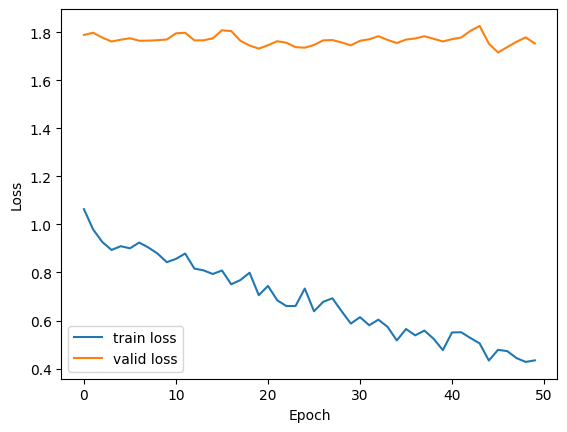

In [200]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [235]:
transforms_train = T.Compose([T.ToTensor(),
                              T.Resize(size = (64, 64)),
                             T.RandomGrayscale(0.5),
                             T.RandomHorizontalFlip(0.5)])

In [236]:
data = datasets.ImageFolder('/home/ahmadrezabaqerzadeh/datasets/skin cancer detection using cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train', 
                            transform = transforms_train)

In [237]:
t, _ = random_split(data, (200, len(data)-200), generator = tc.Generator().manual_seed(42))

In [238]:
train_dataset, valid_dataset = random_split(t, (150, len(t)-150), generator = tc.Generator().manual_seed(42))

In [239]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 50, shuffle = False)

In [268]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-7)
loss_func = nn.CrossEntropyLoss()

In [269]:
loss_train_hist, loss_valid_hist = [], []
acc_train_hist, acc_valid_hist = [], []

In [270]:
N = 50
for i in range(N):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,valid_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = model
    print('model saved!')

Epoch=0: 100%|██████████| 3/3 [00:02<00:00,  1.39batch/s, Accuracy=89.3, loss=0.549]


valid loss=1.915, accuracy=28.0



Epoch=1: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=87.3, loss=0.58] 


valid loss=2.128, accuracy=26.0



Epoch=2: 100%|██████████| 3/3 [00:02<00:00,  1.37batch/s, Accuracy=89.3, loss=0.51] 


valid loss=1.953, accuracy=44.0



Epoch=3: 100%|██████████| 3/3 [00:02<00:00,  1.38batch/s, Accuracy=90, loss=0.632]  


valid loss=1.892, accuracy=32.0



Epoch=4: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=88.7, loss=0.505]


valid loss=2.018, accuracy=26.0



Epoch=5: 100%|██████████| 3/3 [00:02<00:00,  1.37batch/s, Accuracy=88, loss=0.606]  


valid loss=1.914, accuracy=34.0



Epoch=6: 100%|██████████| 3/3 [00:02<00:00,  1.39batch/s, Accuracy=89.3, loss=0.515]


valid loss=1.979, accuracy=30.0



Epoch=7: 100%|██████████| 3/3 [00:02<00:00,  1.34batch/s, Accuracy=88, loss=0.548]  


valid loss=1.903, accuracy=40.0



Epoch=8: 100%|██████████| 3/3 [00:02<00:00,  1.38batch/s, Accuracy=86, loss=0.557]  


valid loss=1.913, accuracy=32.0



Epoch=9: 100%|██████████| 3/3 [00:02<00:00,  1.33batch/s, Accuracy=93.3, loss=0.467]


valid loss=1.842, accuracy=32.0



Epoch=10: 100%|██████████| 3/3 [00:02<00:00,  1.44batch/s, Accuracy=89.3, loss=0.523]


valid loss=1.756, accuracy=34.0



Epoch=11: 100%|██████████| 3/3 [00:02<00:00,  1.38batch/s, Accuracy=90.7, loss=0.544]


valid loss=1.807, accuracy=36.0



Epoch=12: 100%|██████████| 3/3 [00:02<00:00,  1.50batch/s, Accuracy=91.3, loss=0.514]


valid loss=1.753, accuracy=40.0



Epoch=13: 100%|██████████| 3/3 [00:02<00:00,  1.40batch/s, Accuracy=91.3, loss=0.478]


valid loss=1.958, accuracy=32.0



Epoch=14: 100%|██████████| 3/3 [00:02<00:00,  1.34batch/s, Accuracy=89.3, loss=0.523]


valid loss=2.003, accuracy=34.0



Epoch=15: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=93.3, loss=0.402]


valid loss=1.931, accuracy=40.0



Epoch=16: 100%|██████████| 3/3 [00:02<00:00,  1.34batch/s, Accuracy=91.3, loss=0.449]


valid loss=1.843, accuracy=38.0



Epoch=17: 100%|██████████| 3/3 [00:02<00:00,  1.38batch/s, Accuracy=94, loss=0.396]  


valid loss=1.909, accuracy=36.0



Epoch=18: 100%|██████████| 3/3 [00:02<00:00,  1.35batch/s, Accuracy=96.7, loss=0.417]


valid loss=1.829, accuracy=42.0



Epoch=19: 100%|██████████| 3/3 [00:02<00:00,  1.34batch/s, Accuracy=92.7, loss=0.471]


valid loss=1.924, accuracy=38.0



Epoch=20: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=94.7, loss=0.382]


valid loss=1.971, accuracy=36.0



Epoch=21: 100%|██████████| 3/3 [00:02<00:00,  1.34batch/s, Accuracy=94, loss=0.452]  


valid loss=1.878, accuracy=34.0



Epoch=22: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=92.7, loss=0.465]


valid loss=1.966, accuracy=36.0



Epoch=23: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=94.7, loss=0.488]


valid loss=1.882, accuracy=38.0



Epoch=24: 100%|██████████| 3/3 [00:02<00:00,  1.36batch/s, Accuracy=92, loss=0.454]  


valid loss=1.905, accuracy=40.0



Epoch=25: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=91.3, loss=0.404]


valid loss=1.813, accuracy=40.0



Epoch=26: 100%|██████████| 3/3 [00:02<00:00,  1.38batch/s, Accuracy=95.3, loss=0.393]


valid loss=1.724, accuracy=32.0



Epoch=27: 100%|██████████| 3/3 [00:02<00:00,  1.40batch/s, Accuracy=93.3, loss=0.383]


valid loss=1.931, accuracy=28.0



Epoch=28: 100%|██████████| 3/3 [00:02<00:00,  1.43batch/s, Accuracy=95.3, loss=0.407]


valid loss=2.028, accuracy=28.0



Epoch=29: 100%|██████████| 3/3 [00:02<00:00,  1.34batch/s, Accuracy=95.3, loss=0.415]


valid loss=2.106, accuracy=36.0



Epoch=30: 100%|██████████| 3/3 [00:02<00:00,  1.38batch/s, Accuracy=90.7, loss=0.478]


valid loss=1.977, accuracy=34.0



Epoch=31: 100%|██████████| 3/3 [00:02<00:00,  1.41batch/s, Accuracy=96, loss=0.4]    


valid loss=2.009, accuracy=28.0



Epoch=32: 100%|██████████| 3/3 [00:02<00:00,  1.33batch/s, Accuracy=91.3, loss=0.418]


valid loss=1.874, accuracy=36.0



Epoch=33: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=94, loss=0.422]  


valid loss=1.989, accuracy=32.0



Epoch=34: 100%|██████████| 3/3 [00:02<00:00,  1.34batch/s, Accuracy=93.3, loss=0.425]


valid loss=2.014, accuracy=38.0



Epoch=35: 100%|██████████| 3/3 [00:02<00:00,  1.37batch/s, Accuracy=91.3, loss=0.492]


valid loss=1.993, accuracy=40.0



Epoch=36: 100%|██████████| 3/3 [00:02<00:00,  1.39batch/s, Accuracy=95.3, loss=0.357]


valid loss=1.926, accuracy=38.0



Epoch=37: 100%|██████████| 3/3 [00:01<00:00,  1.61batch/s, Accuracy=90, loss=0.468]  


valid loss=1.884, accuracy=38.0



Epoch=38: 100%|██████████| 3/3 [00:02<00:00,  1.40batch/s, Accuracy=92, loss=0.448]  


valid loss=2.166, accuracy=32.0



Epoch=39: 100%|██████████| 3/3 [00:02<00:00,  1.42batch/s, Accuracy=96, loss=0.375]  


valid loss=2.001, accuracy=38.0



Epoch=40: 100%|██████████| 3/3 [00:02<00:00,  1.36batch/s, Accuracy=89.3, loss=0.471]


valid loss=1.926, accuracy=32.0



Epoch=41: 100%|██████████| 3/3 [00:02<00:00,  1.44batch/s, Accuracy=96.7, loss=0.353]


valid loss=1.923, accuracy=32.0



Epoch=42: 100%|██████████| 3/3 [00:02<00:00,  1.44batch/s, Accuracy=96.7, loss=0.367]


valid loss=1.947, accuracy=38.0



Epoch=43: 100%|██████████| 3/3 [00:02<00:00,  1.35batch/s, Accuracy=94.7, loss=0.345]


valid loss=1.831, accuracy=42.0



Epoch=44: 100%|██████████| 3/3 [00:02<00:00,  1.41batch/s, Accuracy=94, loss=0.386]  


valid loss=2.047, accuracy=32.0



Epoch=45: 100%|██████████| 3/3 [00:02<00:00,  1.40batch/s, Accuracy=96.7, loss=0.43]


valid loss=1.937, accuracy=38.0



Epoch=46: 100%|██████████| 3/3 [00:02<00:00,  1.37batch/s, Accuracy=96, loss=0.404]  


valid loss=2.027, accuracy=38.0



Epoch=47: 100%|██████████| 3/3 [00:02<00:00,  1.35batch/s, Accuracy=98, loss=0.31]   


valid loss=1.895, accuracy=40.0



Epoch=48: 100%|██████████| 3/3 [00:02<00:00,  1.45batch/s, Accuracy=96.7, loss=0.368]


valid loss=1.858, accuracy=42.0



Epoch=49: 100%|██████████| 3/3 [00:02<00:00,  1.32batch/s, Accuracy=98.7, loss=0.288]


valid loss=1.924, accuracy=42.0



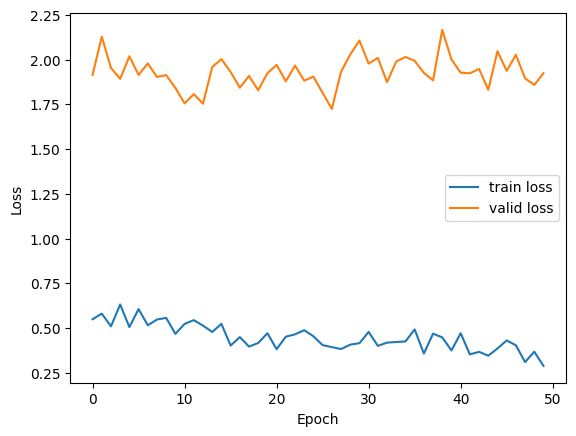

In [271]:
plt.plot(range(N), loss_train_hist, label = 'train loss')
plt.plot(range(N), loss_valid_hist, label = 'valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [272]:
best_loss

1.6777660846710205